In [1]:
#Importing modules

from torchvision import datasets
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torch
import sys

In [2]:
#sys.path.insert(1, '/home/dlinano/Desktop/Autonomous-RC-Car-Milestone-2/Data_Collection') #If training on Jetson
#sys.path.insert(1, 'C:/Users/Owen/Desktop/Projects/Autonomous RC Car/Autonomous-RC-Car-Milestone-2/Data_Collection/Aug6_DataCollection') #if training on remote laptop
print(torch.__version__)

1.6.0


In [3]:
#Custom Dataset Title

In [16]:
class CustomDataset():
    def __init__(self, csv_file, img_path):
        #Transforms
        self.resize = transforms.Resize((224,224))
        self.color = transforms.ColorJitter(0.1,0.1,0.1,0.1)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        #Reading csv File
        self.csv_data = pd.read_csv(csv_file)
        self.img_name_arr = np.asarray(self.csv_data.iloc[:,1]) #2nd column contains names of the images
        self.throttle_label_arr = np.asarray(self.csv_data.iloc[:,3]) #3rd column is Throttle data
        self.steering_label_arr = np.asarray(self.csv_data.iloc[:,4]) #4th column is Steering data
        
        self.label_arr = np.asarray([self.csv_data.iloc[:,3], self.csv_data.iloc[:,4]])
        self.data_length = len(self.csv_data.index)

    def __getitem__(self, index):
        img_name = self.img_name_arr[index] #Getting individual image name
        img = Image.open(img_path + str(img_name)) #Opening image

        #image transformations to tensor
        img_resize = self.resize(img)
        img_color = self.color(img_resize)
        img_tensor = self.to_tensor(img_color)
        img_normalized = self.normalize(img_tensor)

        throttle_label = self.throttle_label_arr[index]
        steering_label = self.steering_label_arr[index]
        img_label = self.label_arr[:,index]
        
        return (img_normalized, img_label)

    def __len__(self):
        return self.data_length

In [17]:
#set device

gpu_avail = torch.cuda.is_available()
if(gpu_avail):
    print("GPU is available, training on GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available, training on CPU")
    device = torch.device('cpu')
    

torch.cuda.empty_cache()

GPU is available, training on GPU


In [18]:
#Choose csv file location depending on if we are training on Jetson or Laptop
csv_file = 'C:/Users/Owen/Desktop/Projects/Autonomous RC Car/Data_Collection/Aug9_DataCollection/Aug9_DataCollection.csv' 
#csv_file = '/home/dlinano/Desktop/Autonomous-RC-Car-Milestone-2/Data_Collection/Aug6_DataCollection/Aug6_DataCollection.csv'

img_path = 'C:/Users/Owen/Desktop/Projects/Autonomous RC Car/Data_Collection/Aug9_DataCollection/'

dataset = CustomDataset(csv_file, img_path)
print(dataset.label_arr.shape)
#img, label = dataset.__getitem__(3)
#print(label)

(2, 1902)


In [19]:
#Generate Training and Validation Datsets

In [20]:
batch_size = 64
random_seed = 42 #To ensure indices are always the same when shuffled below
validation_split = 0.9
shuffle_dataset = True

#Creating the data indices for training and validation sets
dataset_size = len(dataset) #Total number of samples
#print(dataset_size)
indices = list(range(dataset_size)) 
#print(indices) #Check that correct number of samples
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices) #indices have now been shuffled

training_indices, validation_indices = indices[split:], indices[:split]

#Creating data samplers and loaders
training_sampler = SubsetRandomSampler(training_indices)
validation_sampler = SubsetRandomSampler(validation_indices)

training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

len(validation_loader.dataset)

1902

(64, 3, 224, 224)
tensor([110,  84])


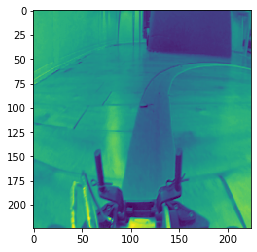

In [21]:
images, label = next(iter(training_loader))
images = images.numpy()
print(images.shape) #batch_size, channels, width, height
plt.imshow(images[3][0], interpolation='nearest')
print(label[3])
plt.show()

In [22]:
#PyTorch Network

#Lowest training loss was approximately 10.9
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        #conv layer sees 224x224x3 image tensor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512,50)
        self.fc2 = nn.Linear(50,2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        #print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv5(x)))
        #print(x.shape)
            
        x = self.flatten(x)
        x = self.dropout(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [23]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1), #input = (3,224,224)
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU() #output = (16,112,112)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2), #input = (16,112,112)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU() #output = (32,56,56)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #input = (32,56,56)
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(2,2),
            nn.ReLU() #output = (64,28,28)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2), #input = (64,28,28)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU() #output = (128,7,7)
        )
        self.Lin1 = nn.Linear(6272, 1000) #128*7*7 = 6272
        self.Lin2 = nn.Linear(1000, 200)
        self.Lin3 = nn.Linear(200,2)
        
    def forward(self,x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)
        x = self.Lin2(x)
        x = self.Lin3(x)
        
        return F.log_softmax(x,dim=1)
        
        
        

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        print(x.shape)
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        print(out.shape)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        print(out.shape)
        #out = out.view(-1, 16 * 8 * 8)
        out = nn.Flatten(out)
        #print(out.shape)
        out = torch.tanh(self.fc1(out))
        print(out.shape)
        out = self.fc2(out)
        print(out.shape)
        return out

In [25]:
model = CNN1()
print(model)

CNN1(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=512, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [26]:
if gpu_avail:
    model.cuda()
    print("moving to gpu")
    


moving to gpu


In [27]:
#training the model

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20

validation_loss_min = np.Inf

for epoch in range(1,num_epochs+1):
    training_loss = 0.0
    validation_loss = 0.0
    
    model.train()
    for data, target in training_loader:
        if torch.cuda.is_available(): #Move to gpu
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad() #Clear the gradients of all optimized variables from the backward pass
        output = model(data) #Forward Pass
        #print(output.shape)
        #print("output: ", output)
        #print("target: ", target)
        loss = criterion(output, target.float()) #batch loss
        #print(loss)
        loss.backward() #backward pass
        optimizer.step() #single optimization step
        training_loss += loss.item()
        #print(loss.item())
    '''    
    model.eval()
    for data, target in validation_loader:
        if torch.cuda.is_available():
            data,target = data.cuda(), target.cuda()
            
        output = model(data)
        loss = criterion(output, target.float())

        validation_loss += loss.item()
    '''    
    training_loss = training_loss / len(training_loader.dataset)
    
    validation_loss = validation_loss / len(validation_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, training_loss, validation_loss))
    '''
    if validation_loss <= validation_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        validation_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'Autonomous_RC_Car.pt')
        validation_loss_min = validation_loss
    '''    

Epoch: 1 	Training Loss: 39808.100850 	Validation Loss: 0.000000
Epoch: 2 	Training Loss: 86.191486 	Validation Loss: 0.000000
Epoch: 3 	Training Loss: 23.438792 	Validation Loss: 0.000000
Epoch: 4 	Training Loss: 19.419892 	Validation Loss: 0.000000
Epoch: 5 	Training Loss: 18.635288 	Validation Loss: 0.000000
Epoch: 6 	Training Loss: 19.115360 	Validation Loss: 0.000000
Epoch: 7 	Training Loss: 18.209705 	Validation Loss: 0.000000
Epoch: 8 	Training Loss: 18.458612 	Validation Loss: 0.000000
Epoch: 9 	Training Loss: 19.283479 	Validation Loss: 0.000000
Epoch: 10 	Training Loss: 18.828301 	Validation Loss: 0.000000
Epoch: 11 	Training Loss: 19.092746 	Validation Loss: 0.000000
Epoch: 12 	Training Loss: 18.450335 	Validation Loss: 0.000000
Epoch: 13 	Training Loss: 18.926844 	Validation Loss: 0.000000
Epoch: 14 	Training Loss: 19.132522 	Validation Loss: 0.000000
Epoch: 15 	Training Loss: 19.089483 	Validation Loss: 0.000000
Epoch: 16 	Training Loss: 18.094892 	Validation Loss: 0.00000

In [ ]:
#######################################################################

In [34]:
model.load_state_dict(torch.load('Autonomous_RC_Car2.pt'))

<All keys matched successfully>

In [ ]:

# obtain one batch of test images
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if gpu_avail:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilitiest
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not gpu_avail else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    print(np.squeeze(output.detach().cpu().numpy()[idx]))
    #ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images.cpu()[idx][0])
    #ax.set_title("({})".format(labels[idx]), color=("green" if preds[idx]==labels[idx].item() else "red"))

In [35]:
single_image_name = img_path + 'Aug9_DataCollection_200.jpg'

img_as_img = Image.open(str(single_image_name))

resize = transforms.Resize((224,224))
#self.center = transforms.CenterCrop(224)
color = transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Transform image to tensor
img_resize = resize(img_as_img)
img_color = color(img_resize)
img_as_tensor = to_tensor(img_color)
img_normalized = normalize(img_as_tensor)
img_normalized.shape

torch.Size([3, 224, 224])

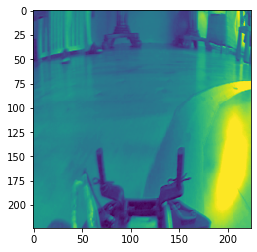

In [36]:
plt.imshow(img_normalized[0], interpolation='nearest')
plt.show()

In [37]:
test = np.append(img_normalized,[])
test = test.reshape(1,3,224,224)
test.shape

(1, 3, 224, 224)

In [38]:
device = torch.device('cuda')
test = torch.from_numpy(test)
test = test.to(device)
test = test.float()

In [39]:
output = model(test)

In [40]:
print(output)

tensor([[112.2895, 108.0377]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:

np.squeeze(output.detach().cpu().numpy())


In [ ]:
output

In [ ]:
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not gpu_avail else np.squeeze(preds_tensor.cpu().numpy())

In [ ]:
preds